In [1]:
from hmmlearn.hmm import GMMHMM
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.stats as scs 

In [2]:

file = 'RB99_1m_Turnover_31000_12120_1213'    #################  轴文件

L = 5      ### 1阶与X阶
diff = 1   ### 1是HLdiff，2是COdiff是，0是没有HLdiff与COdiff
mix = 3    ### GMM mix参数

####################################################################################

file_name = file + '.csv'       
df = pd.read_csv(file_name)
openn = df['open']
close = df['close']
high = df['high'][L:]
low = df['low'][L:]
eob = df['eob']
datelist = pd.to_datetime(eob[L:])

logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))[(L-1):]
logreturnX = np.log(np.array(close[L:]))-np.log(np.array(close[:-L]))
HLdiff = np.log(np.array(high))-np.log(np.array(low))
COdiff = abs(np.log(np.array(close[L:]))-np.log(np.array(openn[L:])))

closeidx = close[L:]

if diff == 1:X = np.column_stack([logreturnX,logreturn,HLdiff])
if diff == 2:X = np.column_stack([logreturnX,logreturn,COdiff])
if diff == 0:X = np.column_stack([logreturnX,logreturn])

len(X)

12115

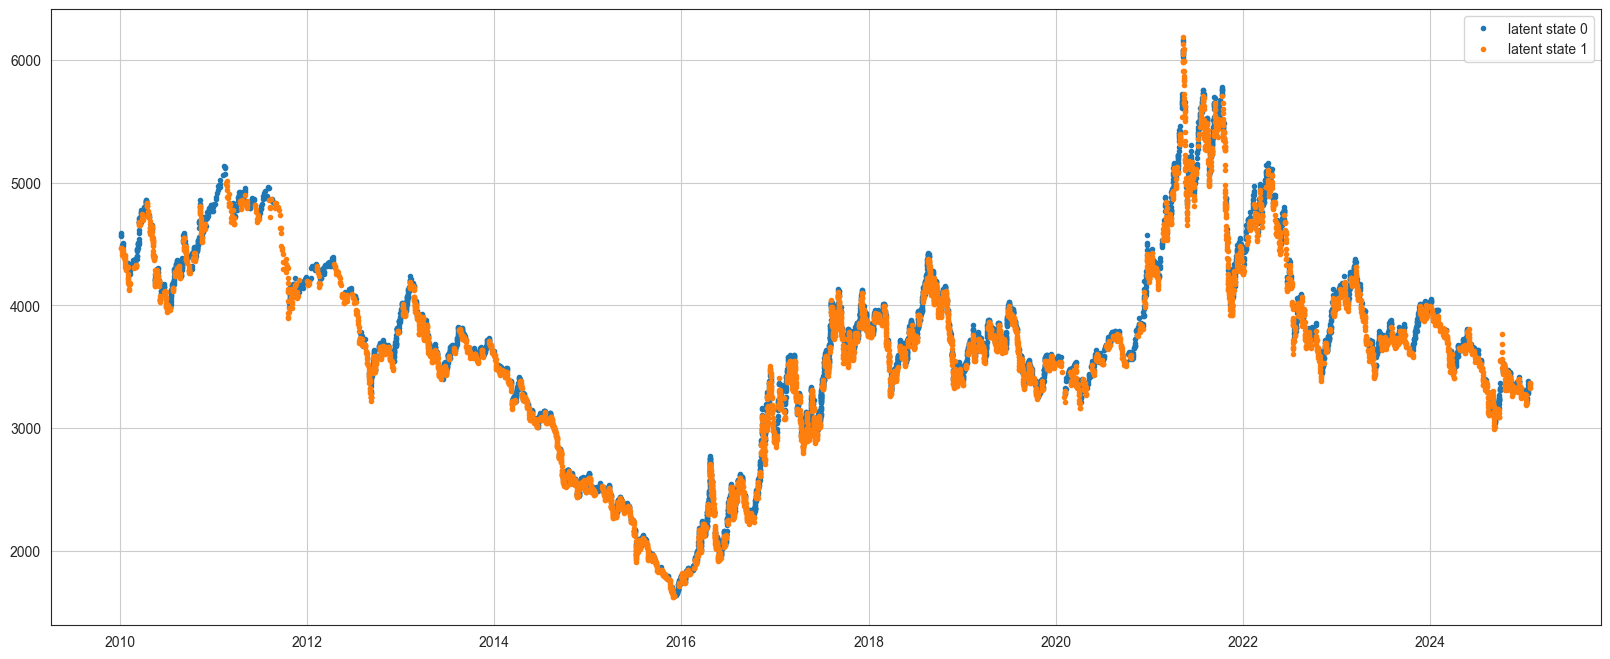

In [3]:
gmm = GMMHMM(n_components = 2, n_mix=mix, covariance_type='diag', n_iter = 369, random_state = 369).fit(X)

latent_states_sequence = gmm.predict(X)   ### 硬标签

state_probabilities = gmm.predict_proba(X)   ### 概率标签

len(latent_states_sequence)
sns.set_style('white')
plt.figure(figsize = (20, 8))
for i in range(gmm.n_components):
    state = (latent_states_sequence == i)
    plt.plot(datelist[state],closeidx[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)


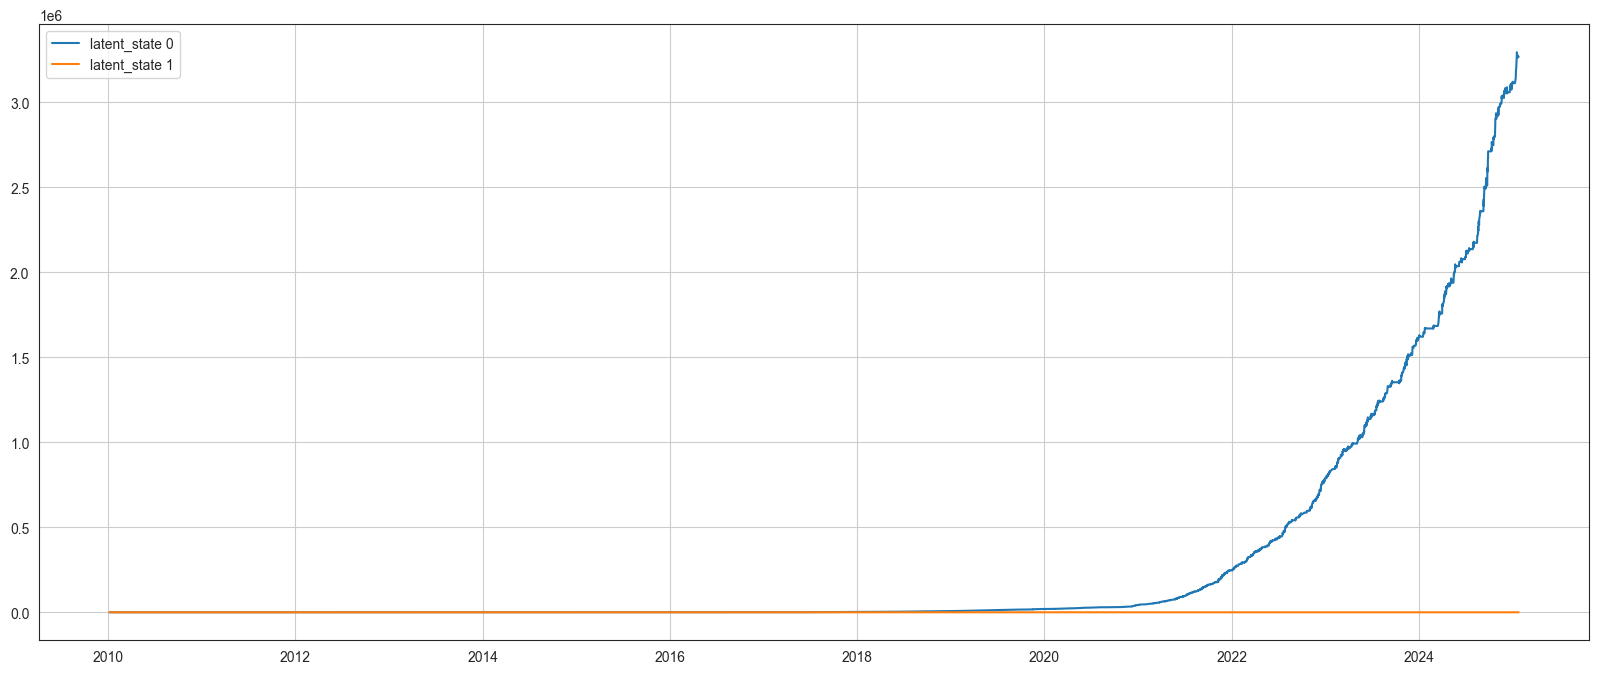

In [4]:
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')

plt.figure(figsize=(20,8))
for i in range(gmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[1:])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i)
    plt.legend(loc='upper left')
    plt.grid(1)

plt.savefig("Label_a.jpg")     ##############  保存图片    #####################


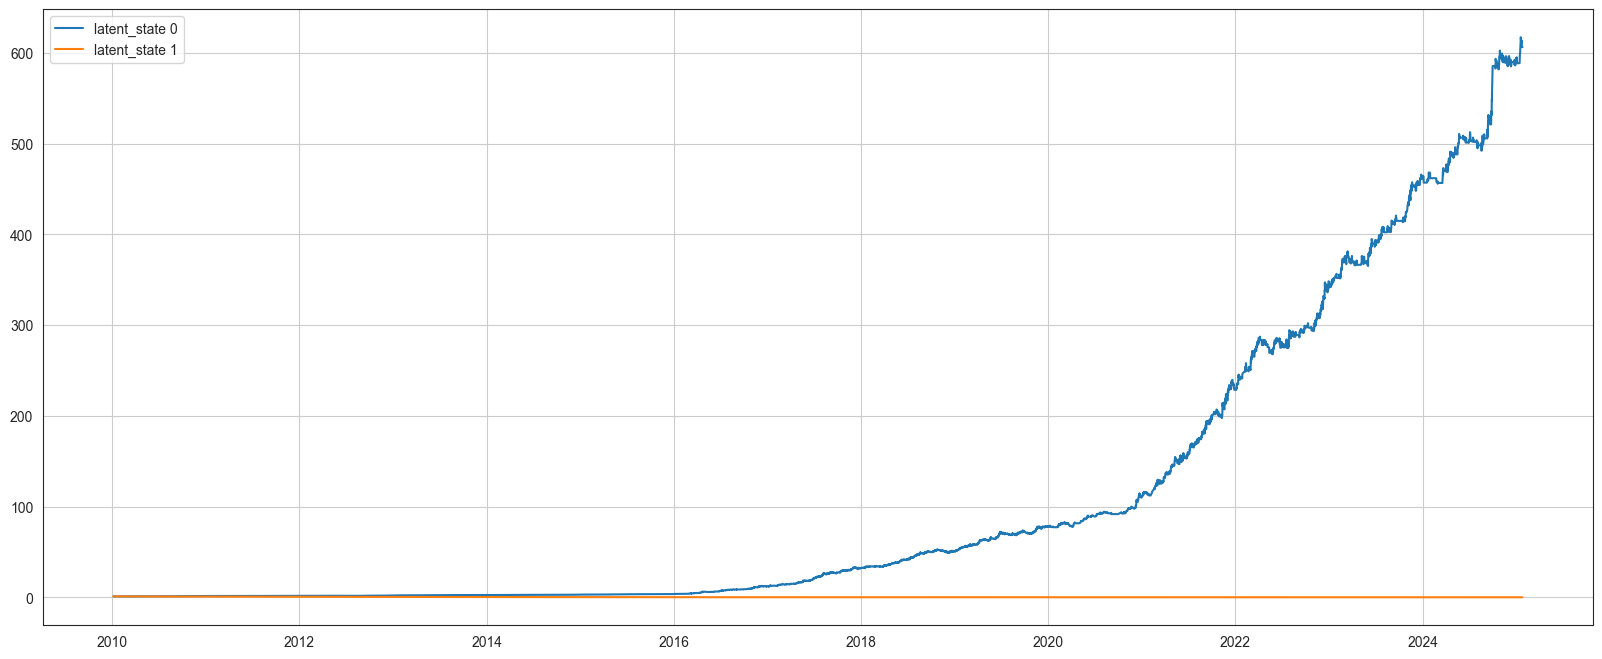

In [5]:
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')

plt.figure(figsize=(20,8))
for i in range(gmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i)
    plt.legend(loc='upper left')
    plt.grid(1)
    
plt.savefig("Label_b.jpg")     ##############  保存图片    #####################

In [6]:
### 硬标签：state
### 自动判断，将标签的 1与0，变为buy为1，sell为0

if sum(data['state 0_return']) > sum(data['state 1_return']):
    data['state'] = abs(data['state'] - 1)
    buy_state = 0  ### 翻转后state=0为做多
else:
    buy_state = 1  #### state=1为做多


    
### 双概率标签：state_0_prob 与 state_1_prob

data['state_0_prob'] = state_probabilities[:, 0]
data['state_1_prob'] = state_probabilities[:, 1]

if buy_state == 0:
    ### 如果 buy_state=0 就交换概率标签
    data['state_0_prob'], data['state_1_prob'] = data['state_1_prob'], data['state_0_prob']


    
### 独立带方向的原始概率标签:state_p1

data['state_p1'] = np.where(
    data['state'] == 1,  
    data['state_1_prob'],  
    -data['state_0_prob']  
)



### 独立概率差值标签：state_p2

data['state_p2'] = data['state_1_prob'] - data['state_0_prob']



### 标签数据导出
data.to_csv(file + "_Label_" + str(L) + str(diff) + str(mix) + ".csv")

In [7]:
data.describe()

,logreturn,state,state 0_return,state 1_return,state_0_prob,state_1_prob,state_p1,state_p2
count,12115.000000,12115.000000,12115.000000,12115.000000,1.211500e+04,1.211500e+04,12115.000000,12115.000000
mean,-0.000025,0.534544,0.000529,-0.000554,4.685058e-01,5.314942e-01,0.066038,0.062988
std,0.007380,0.498826,0.004981,0.005391,4.486645e-01,4.486645e-01,0.937744,0.897329
min,-0.060700,0.000000,-0.056458,-0.060700,4.882779e-204,3.010140e-70,-1.000000,-1.000000
25%,-0.004459,0.000000,0.000000,-0.000613,3.085083e-03,8.517390e-03,-0.991483,-0.982965
50%,0.000074,1.000000,0.000000,0.000000,3.360318e-01,6.639682e-01,0.660885,0.327936
75%,0.004493,1.000000,0.001526,0.000000,9.914826e-01,9.969149e-01,0.996915,0.993830
max,0.064147,1.000000,0.052399,0.064147,1.000000e+00,1.000000e+00,1.000000,1.000000
